In [ ]:
# Install necessary libraries
!pip install tensorflow opencv-python matplotlib numpy pandas scikit-learn pillow

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Install necessary packages
!pip install -q tensorflow opencv-python matplotlib pandas numpy scikit-learn gradio kagglehub

# Mount Google Drive for saving model and results
from google.colab import drive
drive.mount('/content/drive')

# Create project directory
!mkdir -p /content/handwriting_analysis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import os
import kagglehub
import zipfile
import shutil

# Download dataset from Kaggle
print("Downloading dataset...")
try:
    # Use the dataset path you provided
    path = kagglehub.dataset_download("vuppalaadithyasairam/handwriting-based-personality-detection")
    print("Path to dataset files:", path)

    # Extract if it's a zip file
    for file in os.listdir(path):
        if file.endswith('.zip'):
            zip_path = os.path.join(path, file)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('/content/handwriting_analysis/dataset')
            print(f"Extracted {file} to /content/handwriting_analysis/dataset")

    # If the files are already extracted, move them to our project directory
    if not os.path.exists('/content/handwriting_analysis/dataset'):
        shutil.copytree(path, '/content/handwriting_analysis/dataset')
        print(f"Copied dataset to /content/handwriting_analysis/dataset")

except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Please upload the dataset manually to /content/handwriting_analysis/dataset")

# Verify the dataset structure
def print_directory_structure(directory, indent=0):
    for item in sorted(os.listdir(directory)):
        path = os.path.join(directory, item)
        if os.path.isdir(path):
            print("  " * indent + "📁 " + item)
            print_directory_structure(path, indent + 1)
        else:
            print("  " * indent + "📄 " + item)

# Check if our dataset directory exists
if os.path.exists('/content/handwriting_analysis/dataset'):
    print("\nDataset Directory Structure:")
    print_directory_structure('/content/handwriting_analysis/dataset')
else:
    print("\nDataset directory not found. Please check the download or upload the dataset manually.")

Path to dataset files: /kaggle/input/handwriting-based-personality-detection

Dataset Directory Structure:
📁 augmented test
  📁 Agreeableness
    📄 IMG_20200215_162541-1-1.jpg
    📄 IMG_20200215_162541-1-2.jpg
    📄 IMG_20200215_162541-1-5.jpg
    📄 IMG_20200215_162541-1-6.jpg
    📄 IMG_20200215_162541-1-7.jpg
    📄 IMG_20200215_162541-1-8.jpg
    📄 IMG_20200215_162541-1.jpg
    📄 IMG_20200215_162541-2-1.jpg
    📄 IMG_20200215_162541-2-2.jpg
    📄 IMG_20200215_162541-2-5.jpg
    📄 IMG_20200215_162541-2-6.jpg
    📄 IMG_20200215_162541-2-7.jpg
    📄 IMG_20200215_162541-2-8.jpg
    📄 IMG_20200215_162541-2.jpg
    📄 IMG_20200215_162541-3-1.jpg
    📄 IMG_20200215_162541-3-2.jpg
    📄 IMG_20200215_162541-3-5.jpg
    📄 IMG_20200215_162541-3-6.jpg
    📄 IMG_20200215_162541-3-7.jpg
    📄 IMG_20200215_162541-3-8.jpg
    📄 IMG_20200215_162541-3.jpg
    📄 IMG_20200215_162541-4-1.jpg
    📄 IMG_20200215_162541-4-2.jpg
    📄 IMG_20200215_162541-4-5.jpg
    📄 IMG_20200215_162541-4-6.jpg
    📄 IMG_2020

Found 720 images for Agreeableness in train set
Found 648 images for Conscientiousness in train set
Found 576 images for Extraversion in train set
Found 864 images for Neuroticism in train set
Found 608 images for Openness in train set
Found 137 images for Agreeableness in test set
Found 131 images for Conscientiousness in test set
Found 112 images for Extraversion in test set
Found 136 images for Neuroticism in test set
Found 144 images for Openness in test set

Total training samples: 3416
Total testing samples: 660


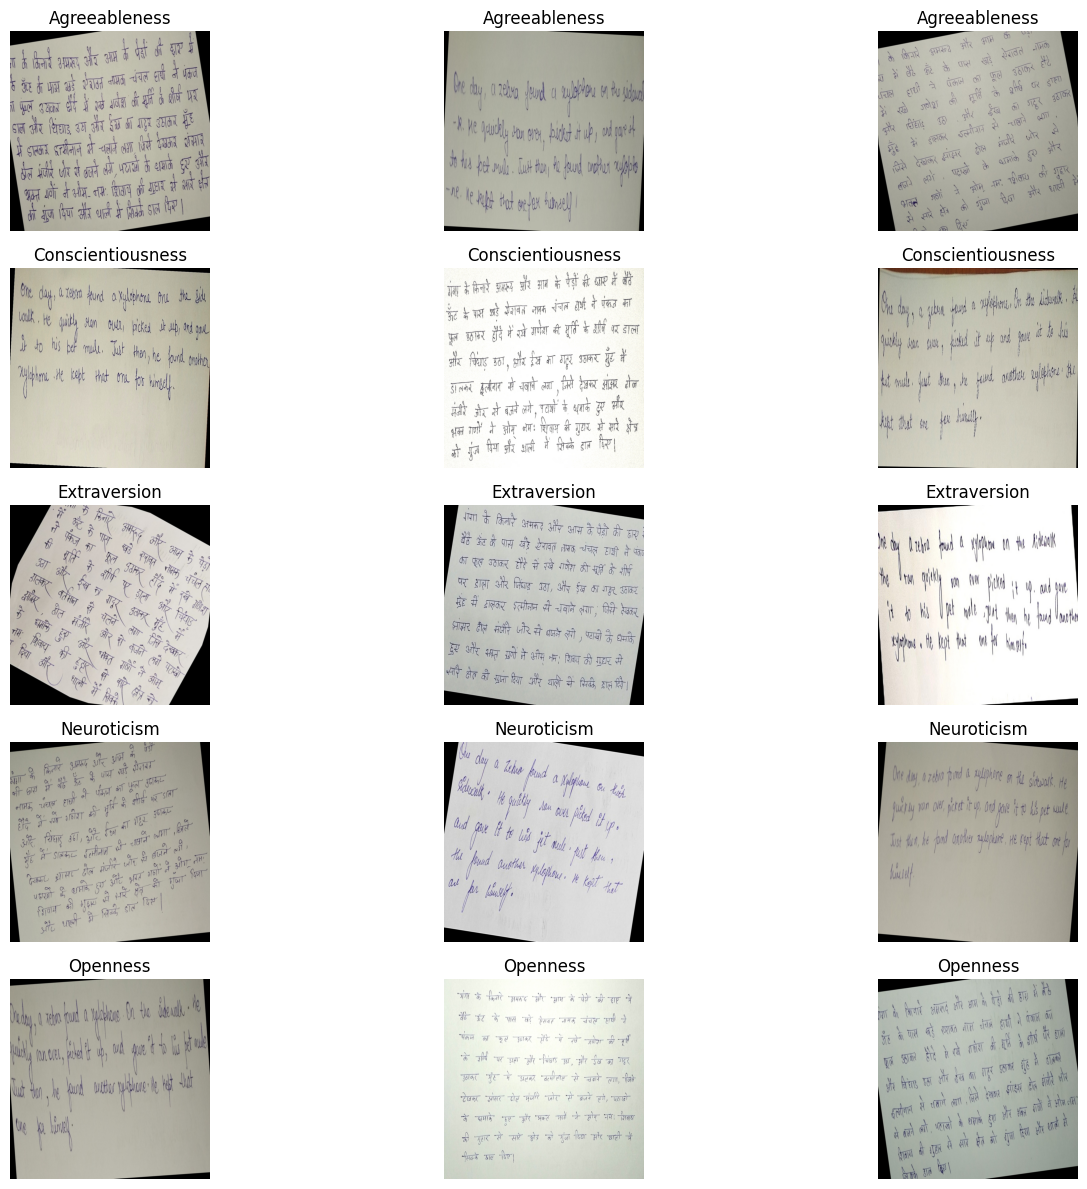

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import to_categorical

# Define personality traits
personality_traits = ['Agreeableness', 'Conscientiousness', 'Extraversion', 'Neuroticism', 'Openness']

# Function to load images from the directory structure
def load_dataset_from_directory(base_dir, subset="train"):
    images = []
    labels = []
    file_paths = []

    # Determine the correct directory path based on subset
    if subset == "train":
        dir_path = os.path.join(base_dir, "augmented train")
    else:
        dir_path = os.path.join(base_dir, "augmented test")

    # Check if directory exists
    if not os.path.exists(dir_path):
        print(f"Directory not found: {dir_path}")
        return images, labels, file_paths

    # Process each trait folder
    for trait_idx, trait in enumerate(personality_traits):
        trait_dir = os.path.join(dir_path, trait)

        # Check if trait directory exists
        if not os.path.exists(trait_dir):
            print(f"Trait directory not found: {trait_dir}")
            continue

        # List all image files
        image_files = [f for f in os.listdir(trait_dir)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f"Found {len(image_files)} images for {trait} in {subset} set")

        # Process each image
        for img_file in image_files:
            img_path = os.path.join(trait_dir, img_file)
            file_paths.append(img_path)
            labels.append(trait_idx)  # Use index as label

    return file_paths, labels

# Function to preprocess images
def preprocess_image(img_path, target_size=(150, 400)):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            # Return blank image if file can't be read
            return np.zeros(target_size)

        # Resize and normalize
        img = cv2.resize(img, target_size)
        img = img / 255.0
        return img
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return np.zeros(target_size)

# Load train and test data paths
base_dir = '/content/handwriting_analysis/dataset'
train_paths, train_labels = load_dataset_from_directory(base_dir, "train")
test_paths, test_labels = load_dataset_from_directory(base_dir, "test")

print(f"\nTotal training samples: {len(train_paths)}")
print(f"Total testing samples: {len(test_paths)}")

# Visualize sample images from each trait
plt.figure(figsize=(15, 12))
for i, trait in enumerate(personality_traits):
    # Find images for this trait
    trait_indices = [idx for idx, label in enumerate(train_labels) if label == i]

    if trait_indices:
        # Display up to 3 images per trait
        for j in range(min(3, len(trait_indices))):
            if trait_indices:
                idx = random.choice(trait_indices)
                trait_indices.remove(idx)

                # Load and display image
                img_path = train_paths[idx]
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.subplot(5, 3, i*3 + j + 1)
                    plt.imshow(img)
                    plt.title(f"{trait}")
                    plt.axis('off')

plt.tight_layout()
plt.show()

# Create a function to prepare data for model training
def prepare_data(file_paths, labels, target_size=(150, 400)):
    if not file_paths:
        return np.array([]), np.array([])

    # Process images
    images = []
    valid_indices = []

    for i, img_path in enumerate(file_paths):
        img = preprocess_image(img_path, target_size)
        images.append(img)
        valid_indices.append(i)

    X = np.array(images).reshape(-1, target_size[0], target_size[1], 1)
    y = np.array([labels[i] for i in valid_indices])

    # Convert to one-hot encoding
    y = to_categorical(y, num_classes=len(personality_traits))

    return X, y

Preparing training data...
Preparing testing data...
Training data shape: (3416, 150, 400, 1)
Training labels shape: (3416, 5)
Testing data shape: (660, 150, 400, 1)
Testing labels shape: (660, 5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 400, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 200, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 200, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 100, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 100, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,045 (56.61 MB)

 Trainable params: 14,839,045 (56.61 MB)

 Non-trainable params: 0 (0.00 B)


Training the model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.2382 - loss: 1.6871

106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - accuracy: 0.2385 - loss: 1.6862 - val_accuracy: 0.1909 - val_loss: 2.3242
Epoch 2/20
  1/106 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.3125 - loss: 1.5818

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3125 - loss: 1.5818 - val_accuracy: 0.1803 - val_loss: 2.1730
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.3182 - loss: 1.4947 - val_accuracy: 0.1803 - val_loss: 2.3317
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 1.3846 - val_accuracy: 0.1788 - val_loss: 2.2794
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.3124 - loss: 1.4484

106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.3125 - loss: 1.4484 - val_accuracy: 0.2076 - val_loss: 2.4707
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3125 - loss: 1.5253 - val_accuracy: 0.1985 - val_loss: 2.5255
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - accuracy: 0.3489 - loss: 1.4169 - val_accuracy: 0.1818 - val_loss: 2.7416


Model saved to '/content/drive/MyDrive/handwriting_personality_model_final.h5'
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2163 - loss: 2.2083

Test accuracy: 0.1803


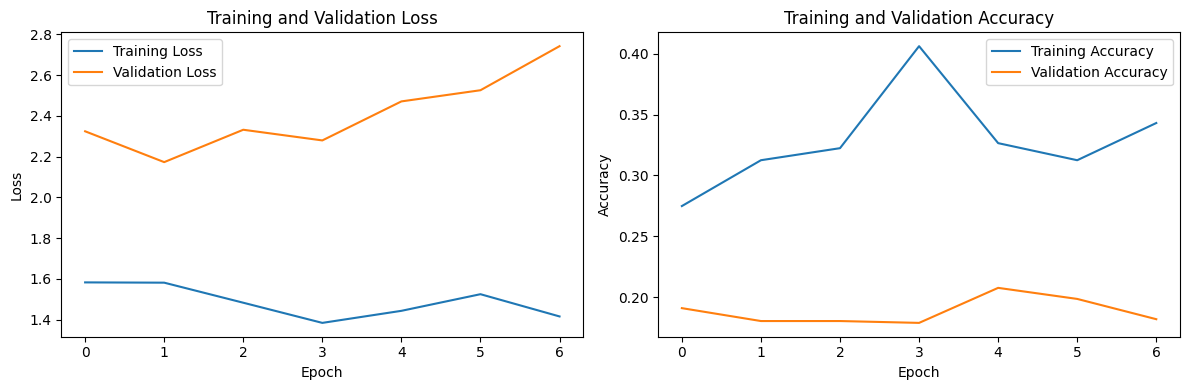

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Check if we have enough data for training
if len(train_paths) > 0 and len(test_paths) > 0:
    # Prepare training and testing data
    print("Preparing training data...")
    X_train, y_train = prepare_data(train_paths, train_labels)

    print("Preparing testing data...")
    X_test, y_test = prepare_data(test_paths, test_labels)

    print(f"Training data shape: {X_train.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    print(f"Testing labels shape: {y_test.shape}")

    # Build the CNN model
    def build_model(input_shape=(150, 400, 1), num_classes=5):
        model = Sequential([
            # First convolutional layer
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
            MaxPooling2D((2, 2)),

            # Second convolutional layer
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),

            # Third convolutional layer
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),

            # Flatten and dense layers
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')  # 5 classes for 5 personality traits
        ])

        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    # Create the model
    model = build_model(input_shape=X_train.shape[1:], num_classes=len(personality_traits))
    model.summary()

    # Set up callbacks
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint(
            filepath='/content/drive/MyDrive/handwriting_personality_model.h5',
            save_best_only=True,
            monitor='val_accuracy'
        )
    ]

    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False  # Handwriting shouldn't be flipped
    )

    # Train the model
    print("\nTraining the model...")
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        steps_per_epoch=len(X_train) // 32,
        epochs=20,
        validation_data=(X_test, y_test),
        callbacks=callbacks
    )

    # Save the model
    model.save('/content/drive/MyDrive/handwriting_personality_model_final.h5')
    print("Model saved to '/content/drive/MyDrive/handwriting_personality_model_final.h5'")

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest accuracy: {accuracy:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

else:
    print("Insufficient data for training. Please check the dataset.")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


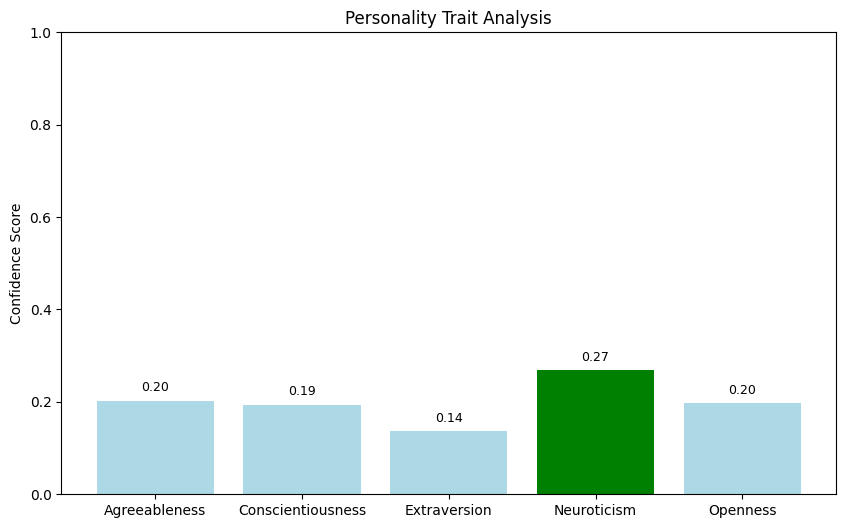

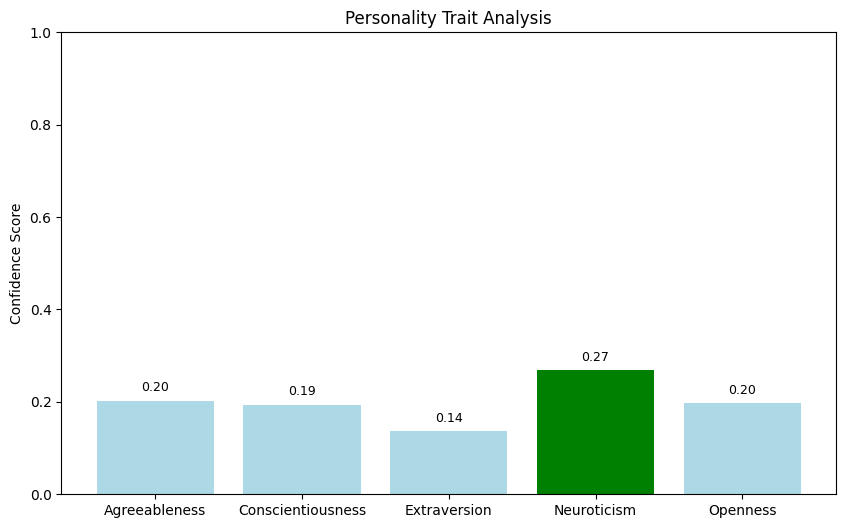

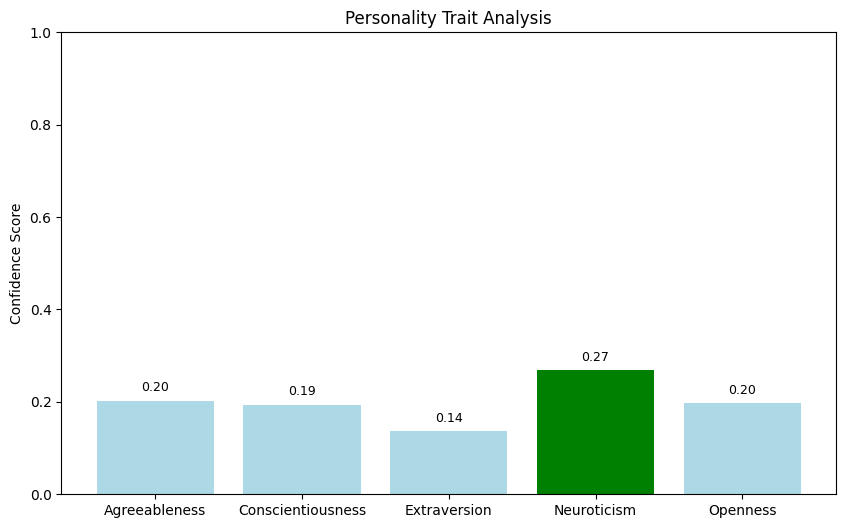

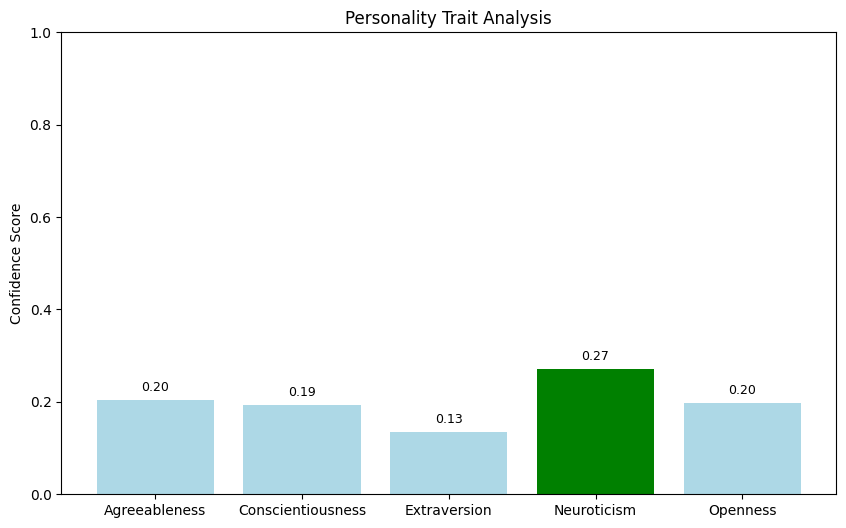

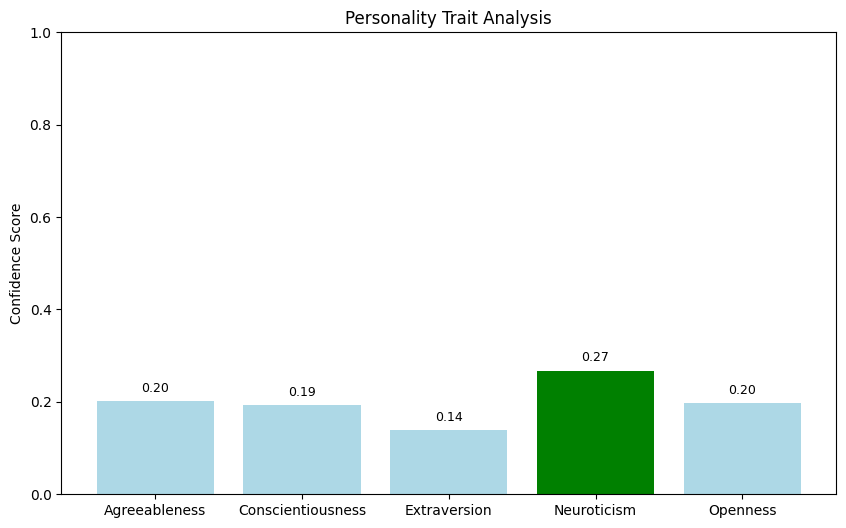

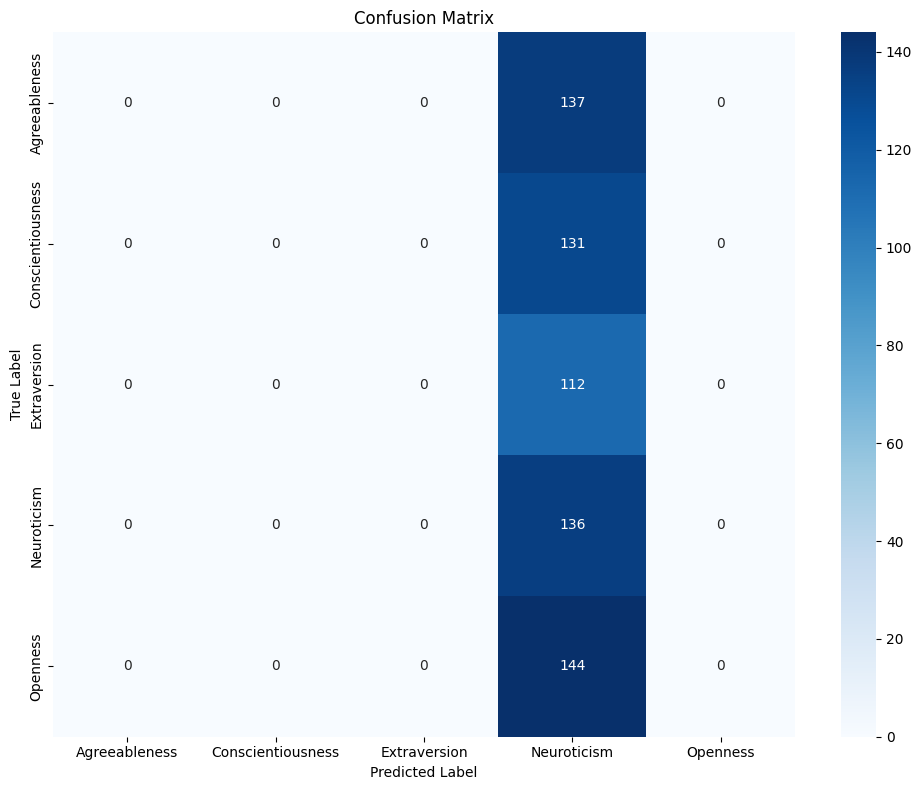

Classification Report:
                   precision    recall  f1-score   support

    Agreeableness       0.00      0.00      0.00       137
Conscientiousness       0.00      0.00      0.00       131
     Extraversion       0.00      0.00      0.00       112
      Neuroticism       0.21      1.00      0.34       136
         Openness       0.00      0.00      0.00       144

         accuracy                           0.21       660
        macro avg       0.04      0.20      0.07       660
     weighted avg       0.04      0.21      0.07       660



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


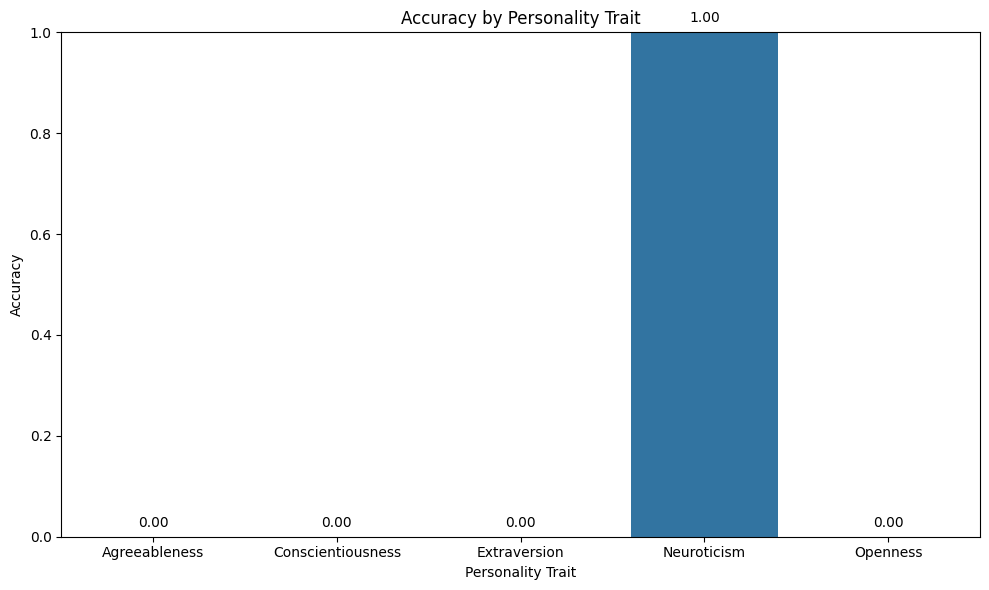

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions for the test set
if 'model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=personality_traits,
                yticklabels=personality_traits)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=personality_traits))

    # Calculate per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    # Plot per-class accuracy
    plt.figure(figsize=(10, 6))
    sns.barplot(x=personality_traits, y=class_accuracy)
    plt.title('Accuracy by Personality Trait')
    plt.xlabel('Personality Trait')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, acc in enumerate(class_accuracy):
        plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center')
    plt.tight_layout()
    plt.show()
else:
    print("Model or test data not available for evaluation.")

In [ ]:
print(model.input_shape)


(None, 150, 400, 1)
